In [1]:
# ROOT Library
from ROOT import TMVA, TFile, TTree, TCut, TString
# DNN Library Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Optimizer SWATS
import swats
#numpy, pandas, matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
from array import array
# ML library
import pickle
import scikitplot as skplt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
# XGBoost Library
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
# Cuda Library
from numba import cuda
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import gc
from scipy.stats import poisson
from importlib import reload

Welcome to JupyROOT 6.19/01


In [2]:
signalFile = TFile.Open("/lustre/samples/di-higgs/pDNN-applied-1122/2tag_sr1_sig.root")
backgroundFile = TFile.Open("/lustre/samples/di-higgs/pDNN-applied-1122/2tag_sr1_bkg.root")

signalTree = signalFile.Get("ntup")
backgroundTree = backgroundFile.Get("ntup")

signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  847545
background events number before cut is:  22274444


In [3]:
sig_variable_names = ["weight","m_hh","m_hh_truth","pytorch_Region4_DNN_600","pytorch_Region4_pDNN_600","pytorch_Region4_pDNN_no260_260","ll_m","is_em","is_me"]

In [4]:
bkg_variable_names = ["weight","m_hh","m_hh_truth","pytorch_Region4_DNN_600","pytorch_Region4_pDNN_600","pytorch_Region4_pDNN_no260_260","ll_m","is_em","is_me"]

In [5]:
signalArray=signalTree.AsMatrix(sig_variable_names)

backgroundArray=backgroundTree.AsMatrix(bkg_variable_names)
    
print(signalArray.shape)
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal_df=pd.DataFrame(data=signalArray,columns=sig_variable_names)
background_df=pd.DataFrame(data=backgroundArray,columns=bkg_variable_names)

(847545, 9)
signal yield before cut is:  188883.40753109788
background yield before cut is: 1859332.62849125


In [6]:
signal_df = signal_df[((signal_df["m_hh_truth"]<605)&(signal_df["m_hh_truth"]>595))]

In [7]:
signal_df_region4=signal_df[(signal_df["ll_m"]<75000.0)&((signal_df["is_em"]==1)|(signal_df["is_me"]==1))]
background_df_region4=background_df[(background_df["ll_m"]<75000.0)&((background_df["is_em"]==1)|(background_df["is_me"]==1))]
SigYield=signal_df_region4["weight"].sum()
BkgYield=background_df_region4["weight"].sum()
SBratio=SigYield/BkgYield
print("signal yield in region 4 is: ",SigYield)
print("background yield in region 4 is: ",BkgYield)
print("S/B ratio is: ",SBratio)

signal yield in region 4 is:  7226.875515906739
background yield in region 4 is:  697642.5163715091
S/B ratio is:  0.0103589952537501


In [8]:
signal_df_region4["label"]=1
background_df_region4["label"]=0
test_df=signal_df_region4.append(background_df_region4)

/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, 'Pytorch Score')

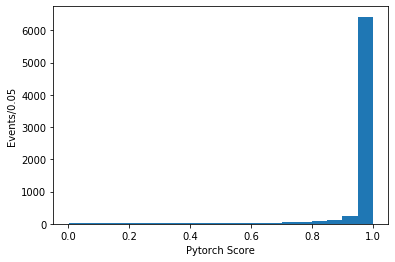

In [9]:
plt.hist(signal_df_region4["pytorch_Region4_DNN_600"].values,bins=20,weights=signal_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

Text(0.5, 0, 'Pytorch Score')

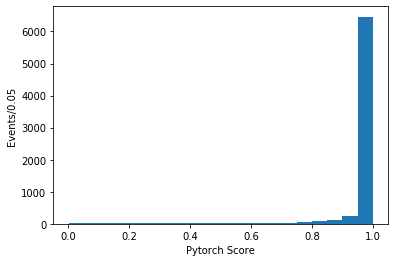

In [10]:
plt.hist(signal_df_region4["pytorch_Region4_pDNN_600"].values,bins=20,weights=signal_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

In [ ]:
plt.hist(background_df_region4["pytorch_Region4_pDNN_no260_260"].values,bins=20,weights=background_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

Text(0.5, 0, 'Pytorch Score')

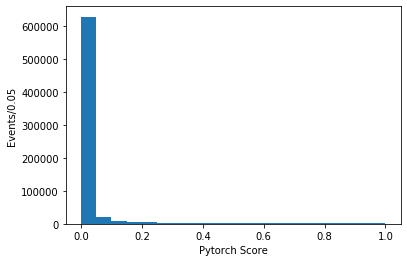

In [11]:
plt.hist(background_df_region4["pytorch_Region4_DNN_600"].values,bins=20,weights=background_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

Text(0.5, 0, 'Pytorch Score')

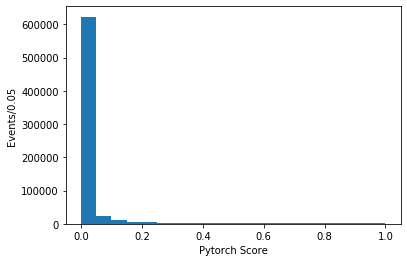

In [12]:
plt.hist(background_df_region4["pytorch_Region4_pDNN_600"].values,bins=20,weights=background_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(test_df["label"].values,test_df["pytorch_Region4_DNN_300"].values)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (DNN at 300GeV)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1123/roc-val-300-DNN-300.pdf', format='pdf', dpi=500)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(test_df["label"].values,test_df["pytorch_Region4_pDNN_no260_260"].values)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (pDNN without 260GeV)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1123/roc-no-600-pDNN-600.pdf', format='pdf', dpi=500)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(test_df["label"].values,test_df["pytorch_Region4_pDNN_800"].values)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Full pDNN at 800GeV)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1123/roc-pDNN-full-800.pdf', format='pdf', dpi=500)